### Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 60.8 MB/s 


In [ ]:
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=fcb0179b83c3df20b7ba0ec62985c106be3e61743466fc886e01a45a252fff88
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
import keras_tuner as kt 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools
import operator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from keras.layers import Layer
from keras_self_attention import SeqSelfAttention
import keras.backend as K
from collections import Counter
import itertools
import operator

### Init Parameters

In [ ]:
maxlength = 20 # Maximum length of each sequence
crossvalidation = KFold(5) # k-fold cross-validation
epochs = 500 # Number of epochs
batch_size = 32 # Batch size
imbalanced = False # Turn off if dataset is not unbalanced
MIC_cutoff = 25

In [ ]:
# Transforming csv file into pandas dataframe, then transferring sequences and MICs to separate lists
classification_sequences = pd.read_csv('/Datasets/ecoli/activity_ecoli_strains_dataset_v1.csv');
#classification_sequences = classification_sequences.loc[(classification_sequences.e_coli > 0)]
amps_sequences = classification_sequences['sequence'].to_list()
print('Number of sequences:', len(amps_sequences)) # Displays the number of total sequences

Number of sequences: 4821


In [ ]:
classification_sequences['seqLength'] = classification_sequences['sequence'].map(lambda x: len(str(x)))

In [ ]:
classification_sequences["seqLength"].describe()

count    4821.000000
mean       19.627878
std        11.364924
min         1.000000
25%        13.000000
50%        17.000000
75%        24.000000
max       140.000000
Name: seqLength, dtype: float64

Text(0.5, 0.98, 'Sequance Lenght distribution')

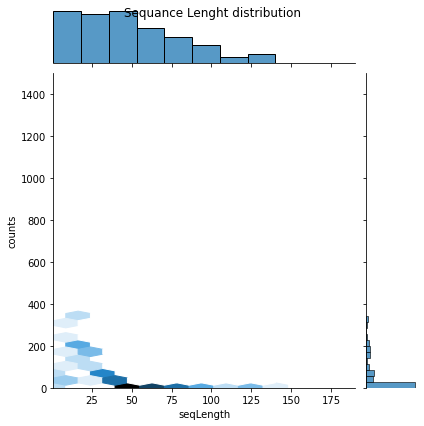

In [ ]:
# statistics about AMP sequences lenght
seqlenghtStatistic = classification_sequences.groupby(['seqLength']).size().reset_index(name='counts')
seqlenghtStatistic
x_len = seqlenghtStatistic['seqLength']
y_count = seqlenghtStatistic['counts']

sns.jointplot(x=x_len, y=y_count,
              kind='hex', xlim=(1,190), ylim=(0,1500))
plt.suptitle("Sequance Lenght distribution")

In [ ]:
df = classification_sequences.drop(classification_sequences[classification_sequences['sequence'].str.len() > maxlength].index)
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength
4,6,KAaaKWAaKaAK,C16,AMD,NaN,6.25,12
5,7,KLlK,C16,AMD,NaN,100.00,4
7,10,kGGGkWGGkGGk,C16,AMD,NaN,25.00,12
8,13,KLllKWLlKlLK,NaN,AMD,NaN,15.00,12
10,16,KLALKLALKAWKAALKLA,NaN,AMD,3.9,NaN,18
...,...,...,...,...,...,...,...
4717,54,KWKLFKKILLKFLHLAKLF,-,-,12.0,NaN,19
4718,55,KYYSRVRGGRSAVLSSLDK,-,-,4.0,NaN,19
4719,56,SSGWVCTLTIECGTVICAC,-,-,200.0,NaN,19
4720,57,VDKGSYLPRPTSHPRPIRV,-,-,3.0,NaN,19


In [ ]:
no_df = df.loc[df['e_coli_atcc'].isnull()]
no_df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength
10,16,KLALKLALKAWKAALKLA,NaN,AMD,3.900000,NaN,18
12,18,ALWKTLLKKVLKAAAK,NaN,AMD,2.526436,NaN,16
13,19,ALWKTLLKKVLKA,NaN,AMD,5.956335,NaN,13
14,20,KLALKAALKAWKAAAKLA,NaN,AMD,8.250000,NaN,18
15,21,KLALKAAAKAWKAAAKAA,NaN,AMD,91.000000,NaN,18
...,...,...,...,...,...,...,...
4717,54,KWKLFKKILLKFLHLAKLF,-,-,12.000000,NaN,19
4718,55,KYYSRVRGGRSAVLSSLDK,-,-,4.000000,NaN,19
4719,56,SSGWVCTLTIECGTVICAC,-,-,200.000000,NaN,19
4720,57,VDKGSYLPRPTSHPRPIRV,-,-,3.000000,NaN,19


In [ ]:
df.dropna(subset=['e_coli_atcc'], inplace= True)
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength
4,6,KAaaKWAaKaAK,C16,AMD,NaN,6.25,12
5,7,KLlK,C16,AMD,NaN,100.00,4
7,10,kGGGkWGGkGGk,C16,AMD,NaN,25.00,12
8,13,KLllKWLlKlLK,NaN,AMD,NaN,15.00,12
11,17,GLRKRLRKFRNKIKEKLKKI,NaN,NaN,NaN,4.00,20
...,...,...,...,...,...,...,...
4507,265,DLRDSWKVIGSDKK,Free,Free,NaN,45.54,14
4608,24,FFLSRIFGK,-,-,NaN,25.00,9
4614,79,TWLKKRRWKKAK,-,-,NaN,64.00,12
4624,265,IAKVALKAL,-,-,NaN,23.60,9


In [ ]:
df["e_coli_atcc"].describe()

count     2312.000000
mean        64.142202
std        782.647575
min          0.005000
25%          4.000000
50%         10.494450
75%         29.164176
max      34353.012973
Name: e_coli_atcc, dtype: float64

In [ ]:
df = df.loc[((df.e_coli_atcc > 0) & (df.e_coli_atcc < MIC_cutoff) )]
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength
4,6,KAaaKWAaKaAK,C16,AMD,NaN,6.25,12
8,13,KLllKWLlKlLK,NaN,AMD,NaN,15.00,12
11,17,GLRKRLRKFRNKIKEKLKKI,NaN,NaN,NaN,4.00,20
31,39,GLRKALRKFRNKIKEALKKI,NaN,NaN,NaN,2.00,20
32,40,GLRKRLRKARNKIKEKLKKI,NaN,NaN,NaN,4.00,20
...,...,...,...,...,...,...,...
4359,117,RRFFFRFRRF,Not included yet,Not included yet,15.00,22.50,10
4360,118,RRIIIRWRRI,Not included yet,Not included yet,3.75,5.63,10
4361,119,RRWWWR,Not included yet,Not included yet,22.50,22.50,6
4624,265,IAKVALKAL,-,-,NaN,23.60,9


In [ ]:
# add non-amp sequnces to dataset to increase the number of negative samples
nonAMP = pd.read_csv('/datasets/non_amp_dataset_and_not_active.csv');
nonAMP = nonAMP.rename(columns={"e_coli": "e_coli_atcc"})
nonAMP['e_coli_atcc'] = nonAMP['e_coli_atcc'].astype(float)
nonAMP

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli_atcc,pseudomonas
0,900001,GEP,NaN,NaN,1000.0,1000
1,900002,MGHP,NaN,NaN,1000.0,1000
2,900003,GTGG,NaN,NaN,1000.0,1000
3,900004,SVTP,NaN,NaN,1000.0,1000
4,900005,MFSPQ,NaN,NaN,1000.0,1000
...,...,...,...,...,...,...
1256,901257,RPWPPR,NaN,NaN,1001.0,1001
1257,901258,WKPLPPR,NaN,NaN,1001.0,1001
1258,901259,FKPLPPH,NaN,NaN,1001.0,1001
1259,901260,RPPWRPPW,NaN,NaN,1001.0,1001


In [ ]:
frames = [df, nonAMP]
df = pd.concat(frames)
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength,pseudomonas
4,6,KAaaKWAaKaAK,C16,AMD,NaN,6.25,12.0,NaN
8,13,KLllKWLlKlLK,NaN,AMD,NaN,15.00,12.0,NaN
11,17,GLRKRLRKFRNKIKEKLKKI,NaN,NaN,NaN,4.00,20.0,NaN
31,39,GLRKALRKFRNKIKEALKKI,NaN,NaN,NaN,2.00,20.0,NaN
32,40,GLRKRLRKARNKIKEKLKKI,NaN,NaN,NaN,4.00,20.0,NaN
...,...,...,...,...,...,...,...,...
1256,901257,RPWPPR,NaN,NaN,NaN,1001.00,NaN,1001.0
1257,901258,WKPLPPR,NaN,NaN,NaN,1001.00,NaN,1001.0
1258,901259,FKPLPPH,NaN,NaN,NaN,1001.00,NaN,1001.0
1259,901260,RPPWRPPW,NaN,NaN,NaN,1001.00,NaN,1001.0


In [ ]:
df['e_coli_atcc'].fillna(2000.0, inplace=True)

In [ ]:
df['e_isActive'] =  np.where(df['e_coli_atcc'] <= MIC_cutoff , True, False)

In [ ]:
df = df.sort_values(by=['e_coli_atcc'], ascending=[True])

In [ ]:
df = df.drop_duplicates(subset='sequence', keep="first")

In [ ]:
df = df[['sequence', 'e_isActive']]
df.head()

,sequence,e_isActive
58,CVKVSVKVGSGVKVSVKVC,True
57,CVKVKVKVGSGVKVKVKVC,True
2654,KWCFRVCYRGICYRRCA,True
60,CVKVQVKVGSGVKVQVKVC,True
2637,AWCFRVCYRGICYRRCR,True


In [ ]:
df.sequence.map(lambda x: len(x)).max()

20

In [ ]:
# statistics about AMPs positive and negative samples
groupActivityStatistic = df.groupby(['e_isActive']).size().reset_index(name='counts')
groupActivityStatistic

,e_isActive,counts
0,False,1258
1,True,1533


In [ ]:
df.to_csv('/content/sample_data/ecoli_atcc_v1_dataset.csv')

In [ ]:
# Split dataset into training (4/5) and test (1/5) sets; out of every 5 sequences, grab the 3rd for the test set
# Dataset will already be sorted by MIC primarily (meaning negative controls are at the bottom) and sequence length secondarily in Excel
included_sequences = df['sequence'].to_list()
included_MICs = df['e_isActive'].to_list()

training_sequences = df['sequence'].to_list()
del training_sequences[2::5]
test_sequences = included_sequences[2::5] # Grabs the 3rd sequence every 5 steps
training_MICs = df['e_isActive'].to_list()
del training_MICs[2::5]
test_MICs = included_MICs[2::5]

In [ ]:
# Zip corresponding sequences and labels together
training_set = list(zip(training_sequences, training_MICs))
test_set = list(zip(test_sequences, test_MICs))

In [ ]:
len(training_set)

2233

In [ ]:
from collections import Counter
Counter(elem[1] for elem in training_set)

Counter({True: 1226, False: 1007})

In [ ]:
len(test_set)

558

In [ ]:
Counter(elem[1] for elem in test_set)

Counter({True: 307, False: 251})

In [ ]:
# Shuffle sequences and labels, with corresponding sequences and labels kept together
# Split the sequences and labels in training_set and test_set into separate lists again
random.seed(16)
random.shuffle(training_set)
training_sequences, training_MICs = zip(*training_set)
random.shuffle(test_set)
test_sequences, test_MICs = zip(*test_set)

In [ ]:
# Function for zero-padding the sequences
def padding(sequences):
    padded_sequences = []
    for i in range(0, len(sequences)):
        if len(sequences[i]) == maxlength:
            padded_sequences.append(sequences[i])
        else:
            padded_sequences.append(sequences[i] + "0" * (maxlength - len(sequences[i])))
    return padded_sequences

In [ ]:
# Pad the training sequences and test sequences
padded_training_sequences = padding(training_sequences)
padded_test_sequences = padding(test_sequences)

In [ ]:
# Mapping of unique characters to integers
chars = ['A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '0']
token_index = dict(zip(chars, range(0, 20)))

In [ ]:
# Function for one-hot encoding sequences into binary arrays
def one_hot_encode(sequences):
    x = np.zeros((len(sequences), maxlength, len(chars))) 
    for i, sequence in enumerate(sequences): 
        for j, char in enumerate(sequence[0 : 20]): 
            index = token_index.get(char) 
            x[i, j, index] = 1 
    return x

In [ ]:
# One-hot encode training and test sequences
print('One-hot encoding the sequences...')
# x_train list contains one-hot encoded versions of the 20 residues of each training sequence
x_train = one_hot_encode(padded_training_sequences) 
# x_test list contains one-hot encoded versions of the 20 residues of each test sequence
x_test = one_hot_encode(padded_test_sequences) 

One-hot encoding the sequences...


In [ ]:
len(x_train)

2233

In [ ]:
# Vectorize labels
y_train = np.asarray(training_MICs).astype('float64')
y_test = np.asarray(test_MICs).astype('float64')

In [ ]:
len(y_train)

2233

In [ ]:
len(x_test)

558

### Preparing The Model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Callbacks (checkpoints to save model weights each time it improves, stops training when there is no improvement)
callbacks = [keras.callbacks.EarlyStopping(monitor = 'acc', patience = 5, mode = 'max'), 
             keras.callbacks.ModelCheckpoint(filepath = '/content/sample_data/cnn_lstm_att_ecoli_atcc_classification_model_v1.h5', monitor = 'acc', 
                                             verbose = 0, save_best_only = True, mode = 'max')]

In [ ]:

# Function that builds model
def build_model(hp):
    model = tf.keras.models.Sequential() # Sequential model
    # Tune the number of units in the LSTM layer; picks an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    # Add CNN layer
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(maxlength, len(chars))))
    model.add(layers.MaxPooling1D(pool_size=2))
    # Add a bidirectional LSTM layer
    model.add(layers.Bidirectional(layers.LSTM(hp_units, return_sequences = True), input_shape = (maxlength, len(chars))))
    model.add(layers.Bidirectional(layers.LSTM(hp_units, return_sequences = True), input_shape = (maxlength, len(chars))))
    model.add(SeqSelfAttention(attention_activation='softmax'))
    # Picks an optimal value of dropout between
    hp_dropout = hp.Float('dropout', min_value = 0.2, max_value = 0.7, step = 0.1)
    model.add(layers.Dropout(hp_dropout)) # Adds a Dropout layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid')) # Sigmoid last-layer activation
    # Tune the learning rate; picks an optimal value from the different learning rates  [1e-1, 1e-2, 2e-2, 3e-2, 1e-3, 1e-4]
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 2e-2, 3e-2, 1e-3, 1e-4])
    model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(hp_learning_rate), metrics = ['acc'])
    # Saving the weights of the model before training start, so we can reset the weights if needed
    model.save_weights('/content/sample_data/initial_cnn_lstm_att_ecoli_atcc_classification_model_v1.h5') 
    return model

In [ ]:
# Subclassing keras tuner to support cross-validation
class tuner_crossvalidation(kt.engine.tuner.Tuner):
    def run_trial(self, trial, x_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = callbacks):
        val_accuracies = []
        for train_indices, test_indices in crossvalidation.split(x_train):
            x_cvtrain, x_cvtest = x_train[train_indices], x_train[test_indices]
            y_cvtrain, y_cvtest = y_train[train_indices], y_train[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(x_cvtrain, y_cvtrain, batch_size = batch_size, epochs = epochs, callbacks = callbacks)
            val_accuracies.append(model.evaluate(x_cvtest, y_cvtest))
        self.oracle.update_trial(trial.trial_id, {'val_acc': np.mean(val_accuracies)})
        self.save_model(trial.trial_id, model)

In [ ]:
tuner = tuner_crossvalidation(hypermodel = build_model, 
                              oracle = kt.oracles.BayesianOptimization(objective = 'val_acc', max_trials = 11))

In [ ]:
# Show search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.003, 'conditions': [], 'values': [0.003], 'ordered': True}


### Find Best Tuning Params

In [ ]:
# Run the hyperparameter search
tuner.search(x_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = callbacks)
best_model = tuner.get_best_models()[0]

Trial 11 Complete [00h 02m 41s]
val_acc: 0.7024847000837326

Best val_acc So Far: 0.7555066138505936
Total elapsed time: 00h 36m 12s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
Completed hyperparameter search. The optimal number of units in the LSTM
layer is {best_hps.get('units')}. The optimal dropout for the dropout layer is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. 
""")


Completed hyperparameter search. The optimal number of units in the LSTM
layer is 512. The optimal dropout for the dropout layer is 0.7000000000000002.
The optimal learning rate for the optimizer is 0.003. 



### Training The Model

In [ ]:
# Function for plotting the accuracy
def plot_acc():
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    plt.figure(1)
    plt.plot(epochs, acc, 'b-', label = 'Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()  

In [ ]:
# Build and train the model with most optimal hyperparameters on all training sequences; plotting the loss and accuracy
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = callbacks)

Epoch 1/500
70/70 [==============================] - 12s 25ms/step - loss: 1.5777 - acc: 0.5208
Epoch 2/500
70/70 [==============================] - 1s 17ms/step - loss: 0.3544 - acc: 0.8728
Epoch 3/500
70/70 [==============================] - 1s 17ms/step - loss: 0.2649 - acc: 0.9136
Epoch 4/500
70/70 [==============================] - 1s 17ms/step - loss: 0.2094 - acc: 0.9279
Epoch 5/500
70/70 [==============================] - 1s 17ms/step - loss: 0.1878 - acc: 0.9324
Epoch 6/500
70/70 [==============================] - 1s 17ms/step - loss: 0.1728 - acc: 0.9409
Epoch 7/500
70/70 [==============================] - 1s 16ms/step - loss: 0.1986 - acc: 0.9507
Epoch 8/500
70/70 [==============================] - 1s 17ms/step - loss: 0.1322 - acc: 0.9561
Epoch 9/500
70/70 [==============================] - 1s 17ms/step - loss: 0.1623 - acc: 0.9579
Epoch 10/500
70/70 [==============================] - 1s 17ms/step - loss: 0.1914 - acc: 0.9557
Epoch 11/500
70/70 [============================

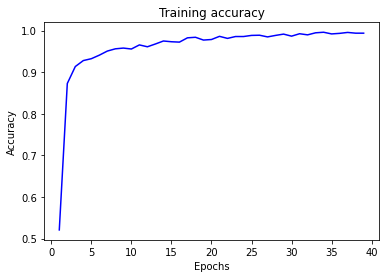

In [ ]:
# Plots figure of accuracy
plot = plot_acc()

### Evaluatation

In [ ]:
# Evaluate optimised model on a never-seen before test set
test_score = model.evaluate(x_test, y_test)
print('Test score (loss value, validation accuracy): ', test_score)

18/18 [==============================] - 2s 12ms/step - loss: 0.3259 - acc: 0.9677
Test score (loss value, validation accuracy):  [0.32594364881515503, 0.9677419066429138]


In [ ]:
# Load our best model
model = load_model('/content/sample_data/cnn_lstm_att_ecoli_atcc_classification_model_v1.h5', custom_objects={"SeqSelfAttention": SeqSelfAttention})

In [ ]:
# Function for plotting the ROC and AUC
def plot_roc_auc():
    plt.figure(2)  
    plt.plot([0, 1], [0, 1], 'g--') # plots the diagonal line where fpr = tpr
    plt.plot(fpr, tpr, label = 'AUC = {:.3f}'.format(roc_auc))
    plt.scatter(fpr[max_value], tpr[max_value], marker = 'o', color = 'red', label = 'Best decision boundary = {:.5f}'.format(best_threshold))
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc = 'best')
    plt.show

In [ ]:
# Function for plotting the confusion matrix
def plot_conf_matrix():
    plt.figure(3)
    plt.imshow(conf_matrix, cmap = plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted label', fontweight = 'bold')
    plt.ylabel('True label', fontweight = 'bold')
    labels = ['Non-antimicrobial', 'Antimicrobial']
    plt.xticks([0, 1], labels)
    plt.yticks([0, 1], labels, rotation = 90, va = 'center')
    thresh = conf_matrix.max()/2
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
         plt.text(j, i, conf_matrix[i, j], ha = 'center', color = 'white' if conf_matrix[i, j] > thresh else "black")
    plt.colorbar()
    plt.show()

Best threshold = 0.974473


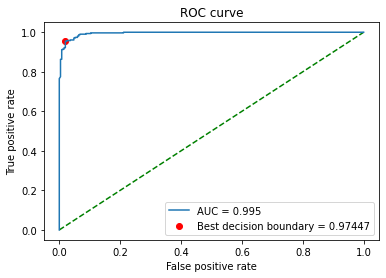

In [ ]:
# Plot the ROC curve and AUC; determine decision boundary   
y_pred = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
J = tpr - fpr # Using Youden's J statistic for calculation of best threshold
max_value = np.argmax(J)
best_threshold = thresholds[max_value]
print('Best threshold = %f' % (best_threshold))
plot2 = plot_roc_auc()

[[246   5]
 [ 14 293]]


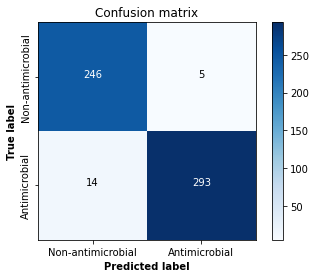

In [ ]:
# Plot the confusion matrix
for i in range(len(y_pred)):
    if y_pred[i] >= best_threshold:
        y_pred[i] = 1
    else: y_pred[i] = 0
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
plot3 = plot_conf_matrix()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       251
         1.0       0.98      0.95      0.97       307

    accuracy                           0.97       558
   macro avg       0.96      0.97      0.97       558
weighted avg       0.97      0.97      0.97       558

